### Installation

In [1]:
# !pip install numpy pandas scikit-learn matplotlib networkx \
#     python-louvain igraph leidenalg node2vec python-dotenv \
#     GitPython PyGithub pydantic litellm torch

### Imports

In [2]:
from collections import Counter
import community as community_louvain
from dotenv import load_dotenv
import git
from github import Auth, Github
import igraph as ig
import json
import leidenalg
from litellm import completion, RateLimitError
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec
import numpy as np
import os
from pathlib import Path
from pydantic import BaseModel
import random
import re
import shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time
import tomllib
import torch
import torch.nn as nn
import torch.optim as optim
import warnings

warnings.filterwarnings("ignore")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
load_dotenv()
print("device:", device)

/Users/vedpatwardhan/Documents/masters/y2_autumn/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: mps


### Data Preparation

Only provided for illustration, the data has already been provided for the analysis.

You will need a `GITHUB_TOKEN` and a `GEMINI_API_KEY` to run the code under this section.

In [ ]:
# # list upto 1000 Python repos with the most stars
# g = Github(auth=Auth.Token(os.getenv("GITHUB_TOKEN")))
# limit = 1000
# repos = []
# for repo in g.search_repositories(query="language:Python stars:>10000", order="desc"):
#     repos.append({
#         "name": repo.name,
#         "clone_url": repo.clone_url,
#         "stargazers_count": repo.stargazers_count
#     })
#     if len(repos) >= limit:
#         break

# # save to a json file
# with open("repos.json", "w") as f:
#     json.dump(repos, f)

In [ ]:
# def shallow_clone(repo_url: str, repo_name: str):
#     """
#     Clone a repository to a temporary folder, without the commit history and large files.

#     Args:
#         repo_url (str): The URL of the repository to clone.
#         repo_name (str): The name of the repository to clone.
#     """
#     folder_path = f"./temp_clones/{repo_name}"
#     shutil.rmtree(folder_path, ignore_errors=True)
#     git.Repo.clone_from(repo_url, folder_path, depth=1, filter="blob:limit=1m")
#     print("Cloned!")

In [ ]:
# def list_tree(root_dir: str) -> list[str]:
#     """
#     List all files in a directory and its subdirectories.

#     Args:
#         root_dir (str): The root directory to list.

#     Returns:
#         list: A list of file paths.
#     """
#     files = []
#     root = Path(root_dir)
#     for path in root.rglob("*"):
#         trimmed_path = path.relative_to(root_dir)
#         if str(trimmed_path).startswith("."):
#             continue
#         files.append(str(trimmed_path))
#     return files

In [ ]:
# def wait_loop():
#     """
#     The free Gemini API has rate limits of 15 requests per minute.
#     This function waits for 15 seconds before retrying for uninterrupted usage.
#     """
#     print(f"We have hit the rate limits!")
#     seconds = 15
#     while seconds > 0:
#         print(
#             (
#                 f"Next try to call the API in {'' if seconds >= 10 else '0'}"
#                 f"{seconds} seconds"
#             ),
#             end="\r",
#         )
#         seconds -= 1
#         time.sleep(1)


# def rate_limit_completion(*args, **kwargs):
#     """
#     We're applying this wrapper to the LiteLLM completion function to retry on rate limit errors.
#     Together with the wait_loop function, this ensures uninterrupted usage of the Gemini API for free.
#     """
#     try:
#         response = completion(*args, **kwargs)
#         return response.json()
#     except RateLimitError:
#         wait_loop()
#         return rate_limit_completion(*args, **kwargs)

In [ ]:
# # Following is the prompt used to extract the files that would contain the dependencies for a Python project
# system_prompt = """
# You have been provided with a recursive file-tree of a python project.

# You need to list the files out of that tree that contain the dependencies for the project.

# This could include either a requirements.txt file or a pyproject.toml file.

# There could be possible prefixes and suffixes to the names but the file extensions are to be strictly followed.

# Never choose a .py or .cfg file or a file that doesn't contain requirement or pyproject in the name.
# """

# # Following is the output format we expect from the LLM
# class GetLibFilesResponse(BaseModel):
#     lib_files: list[str]

In [ ]:
# def get_lib_files(file_tree: list[str]) -> list[str]:
#     """
#     Gets the file_tree for a Python project (generated using previous utilities) and
#     uses the LLM to get the list of files that potentially contain the dependencies
#     for the project.

#     Args:
#         file_tree (list[str]): The file tree of the Python project.

#     Returns:
#         list[str]: The list of files that contain the dependencies for the project.
#     """
#     lib_files = GetLibFilesResponse(
#         **json.loads(
#             rate_limit_completion(
#                 model="gemini/gemini-2.5-flash-lite",
#                 messages=[
#                     {"role": "system", "content": system_prompt},
#                     {"role": "user", "content": "FILE TREE:\n\n" + "\n".join(file_tree)}
#                 ],
#                 response_format={
#                     "type": "json_object",
#                     "response_schema": GetLibFilesResponse.model_json_schema(),
#                 },
#             )["choices"][0]["message"]["content"]
#         )
#     ).lib_files
#     return lib_files

In [ ]:
# def read_libs(file_path: str) -> list[str]:
#     """
#     For a file detected by the LLM, extracts the dependencies from it.
#     Depending on whether it's a requirements.txt or pyproject.toml file,
#     the dependencies are extracted differently. Any other files are ignored.

#     Args:
#         file_path (str): The path to the file to read.

#     Returns:
#         list[str]: The list of dependencies extracted from the file.
#     """
#     # if the file doesn't exist, return an empty list
#     if not os.path.exists(file_path):
#         return []

#     # if it's a pyproject.toml
#     if file_path.endswith(".toml"):
#         with open(file_path, "rb") as file:
#             # load the toml file
#             try:
#                 toml = tomllib.load(file)
#             except Exception:
#                 return []

#             # if it's a regular project
#             if "project" in toml and "dependencies" in toml["project"]:
#                 libs = toml["project"]["dependencies"]
#             # if it's a poetry project
#             elif (
#                 "tool" in toml
#                 and "poetry" in toml["tool"]
#                 and "dependencies" in toml["tool"]["poetry"]
#             ):
#                 libs = toml["tool"]["poetry"]["dependencies"]
#             else:
#                 return []

#     # if it's a requirements.txt
#     elif file_path.endswith(".txt"):
#         with open(file_path) as file:
#             try:
#                 libs = file.read().split("\n")
#             except Exception:
#                 return []
#     else:
#         return []

#     # process each line to get rid of version-specifications and other characters
#     trimmed_libs = []
#     for lib in libs:
#         match = re.search(r'[^a-zA-Z0-9_-]', lib)
#         trimmed_lib = lib[:match.start()] if match else lib
#         if trimmed_lib:
#             trimmed_libs.append(trimmed_lib)
#     return trimmed_libs

In [ ]:
# def process_repo(repo_url: str, repo_name: str) -> list[str]:
#     """
#     Basically puts it all together by using the utils we created so far.

#     Args:
#         repo_url (str): The URL of the repository.
#         repo_name (str): The name of the repository.

#     Returns:
#         list[str]: The list of dependencies extracted from the repository.
#     """
#     print("Repo Name:", repo_name)
#     print("Repo URL:", repo_url)
#     folder_path = f"./temp_clones/{repo_name}"

#     # clone the repo
#     shallow_clone(repo_url, repo_name)

#     # get the file tree
#     file_tree = list_tree(folder_path)

#     # use the LLM to get files that contain dependencies
#     lib_files = get_lib_files(file_tree)
#     print("Lib Files:", lib_files)

#     # get the dependencies from each such file and remove duplucates
#     libs = []
#     for lib_file in lib_files:
#         libs += read_libs(os.path.join(folder_path, lib_file))
#     libs = sorted(list(set(libs)))

#     print("Libs:", libs)
#     print()
#     return libs

In [ ]:
# # we've computed the dependencies for the first 100 repos
# for idx, repo in enumerate(repos[:100]):
#     print("Repo Number:", idx + 1)
#     libs = process_repo(repo["clone_url"], repo["name"])
#     repo["libs"] = libs

# # store the updates to create the dataset
# with open("repos.json", "w") as f:
#     json.dump(repos, f, indent=4)

### Basic Analysis of the Data

In [3]:
# load data
with open("repos.json") as f:
    repos = json.load(f)

# get repos for which we extracted libs
repos = [repo for repo in repos if "libs" in repo]
print(f"Number of valid repos: {len(repos)}")

Number of valid repos: 97


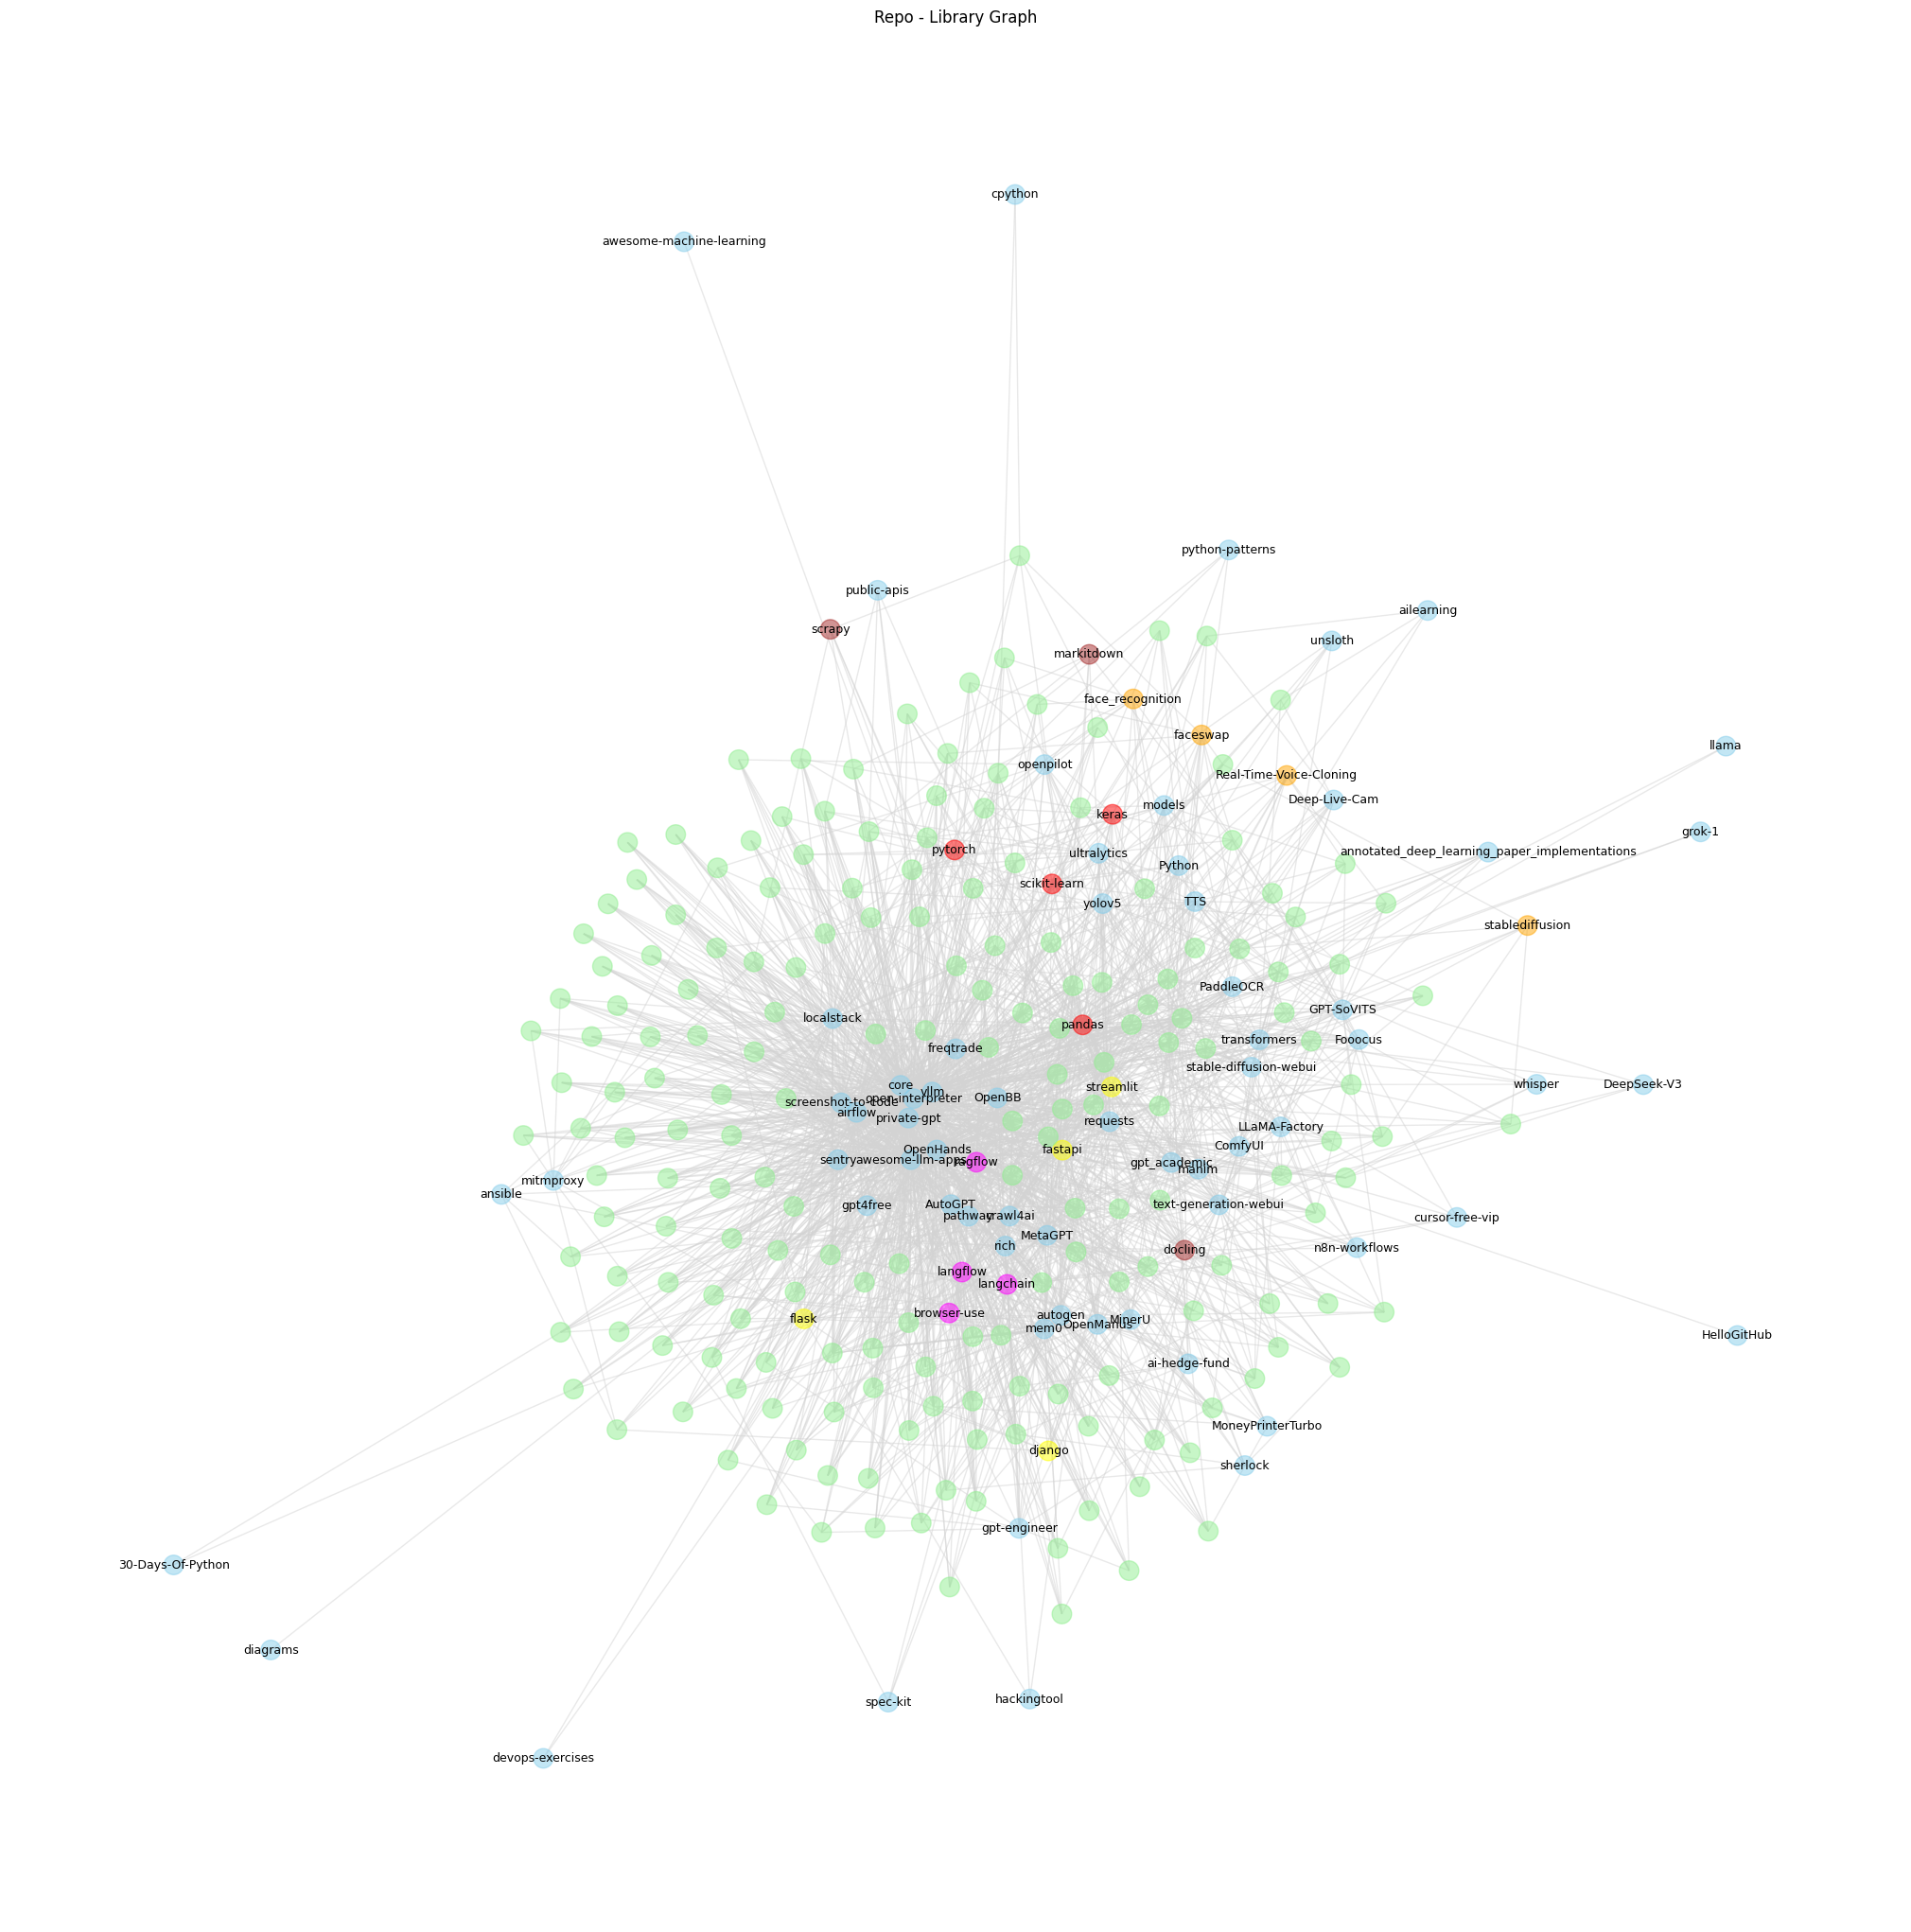

In [4]:
# count how often each library appears across repos
lib_counts = Counter()
for repo in repos:
    for lib in repo["libs"]:
        lib_counts[lib] += 1

# only retain libraries used by 6 or more repos
valid_libs = {lib for lib, c in lib_counts.items() if c >= 6}

# manually identified communities
manual_communities = {
    "agentic_devops": {
        "nodes": ["langchain", "langflow", "browser-use", "ragflow"],
        "color": "magenta",
    },
    "ml_core": {
        "nodes": ["pandas", "scikit-learn", "pytorch", "keras"],
        "color": "red",
    },
    "audio_visual": {
        "nodes": ["face_recognition", "faceswap", "stablediffusion", "Real-Time-Voice-Cloning"],
        "color": "orange",
    },
    "web": {
        "nodes": ["streamlit", "django", "fastapi", "flask"],
        "color": "yellow",
    },
    "scraping": {
        "nodes": ["docling", "scrapy", "markitdown"],
        "color": "brown",
    }
}

G = nx.Graph()

for repo in repos:
    repo_name = repo["name"]

    # filter repo's libs to only valid ones
    repo_libs = [lib for lib in repo["libs"] if lib in valid_libs]

    # skip repos that have no valid libs
    if len(repo_libs) == 0:
        continue

    # add repo node (different colors for certain repositories for manual marking communities)
    category = [key for key, value in manual_communities.items() if repo_name in value["nodes"]]
    if not len(category):
        G.add_node(repo_name, type="repo")
    else:
        G.add_node(repo_name, type="repo", color=manual_communities[category[0]]["color"])

    # add library nodes + edges
    for lib in repo_libs:
        if lib not in G.nodes:
            G.add_node(lib, type="lib")
        G.add_edge(repo_name, lib)


repo_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "repo"]

# colors
colors = [
    G.nodes[n]["color"] if "color" in G.nodes[n]
    else "skyblue" if G.nodes[n]["type"] == "repo"
    else "lightgreen"
    for n in G
]

# create a spring layout
pos = nx.spring_layout(G, k=10, iterations=10000, seed=42)

plt.figure(figsize=(20, 20))
nx.draw(G, pos, node_color=colors, node_size=220, edge_color="lightgrey", alpha=0.5)

# label repo nodes only to avoid clutter
nx.draw_networkx_labels(G, pos, labels={r: r for r in repo_nodes}, font_size=9)

plt.title("Repo - Library Graph")
plt.axis("off")
plt.show()

In [5]:
# get repo and lib nodes
repo_nodes = [n for n, d in G.nodes(data=True) if d["type"] == "repo"]
lib_nodes  = [n for n, d in G.nodes(data=True) if d["type"] == "lib"]
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Repos: {len(repo_nodes)}, Libraries: {len(lib_nodes)}")

Total nodes: 272
Total edges: 2155
Repos: 84, Libraries: 188


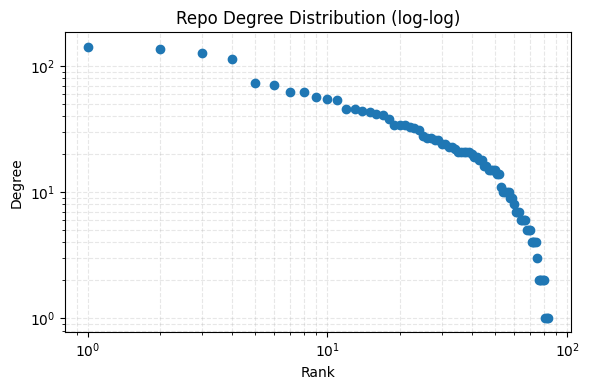

In [6]:
# plot degree distributions for repos
repo_degrees = [G.degree(n) for n in repo_nodes]
repo_degrees = sorted(repo_degrees, reverse=True)

# we're plotting log-log plots given it's a heavy-tailed distribution
plt.figure(figsize=(6, 4))
plt.loglog(repo_degrees, marker="o", linestyle="None")
plt.title("Repo Degree Distribution (log-log)")
plt.xlabel("Rank")
plt.ylabel("Degree")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# we can further analyse nodes based on degree, betweenness and eigenvector centrality
def top_5(dictionary):
    return sorted(dictionary.items(), key=lambda x: x[1], reverse=True)[:5]

# compute degree centrality
deg_cent = nx.degree_centrality(G)

# filter to only include repo nodes
repo_deg_cent = {
    n: c for n, c in deg_cent.items() 
    if G.nodes[n].get("type") == "repo"
}

# print results
print("Top 5 nodes by degree centrality:")
for node, score in top_5(repo_deg_cent):
    print(f"{node}: {score:.4f}")

Top 5 nodes by degree centrality:
awesome-llm-apps: 0.5314
private-gpt: 0.5203
vllm: 0.5055
open-interpreter: 0.4686
OpenHands: 0.4207


### Constructing Repo-Repo Graph

In [8]:
# connect repos that share at least one lib
RG = nx.Graph()
lib_nodes  = [n for n, d in G.nodes(data=True) if d["type"] == "lib"]
weights = dict()
for lib in lib_nodes:
    neighbors = [n for n in G.neighbors(lib) if G.nodes[n]["type"] == "repo"]
    for i, a in enumerate(neighbors):
        for b in neighbors[i + 1:]:
            if (
                (a in weights and b in weights[a])
                or (b in weights and a in weights[b])
            ):
                weights[a][b] += 1
            else:
                if a in weights:
                    weights[a][b] = 1
                else:
                    weights[a] = {b: 1}

# prepare a list of undirected edges
edges = []
for a in weights:
    for b in weights[a]:
        edges.append((a, b, weights[a][b]))

# add weighted edges
RG.add_weighted_edges_from(edges)
repo_nodes = RG.nodes()

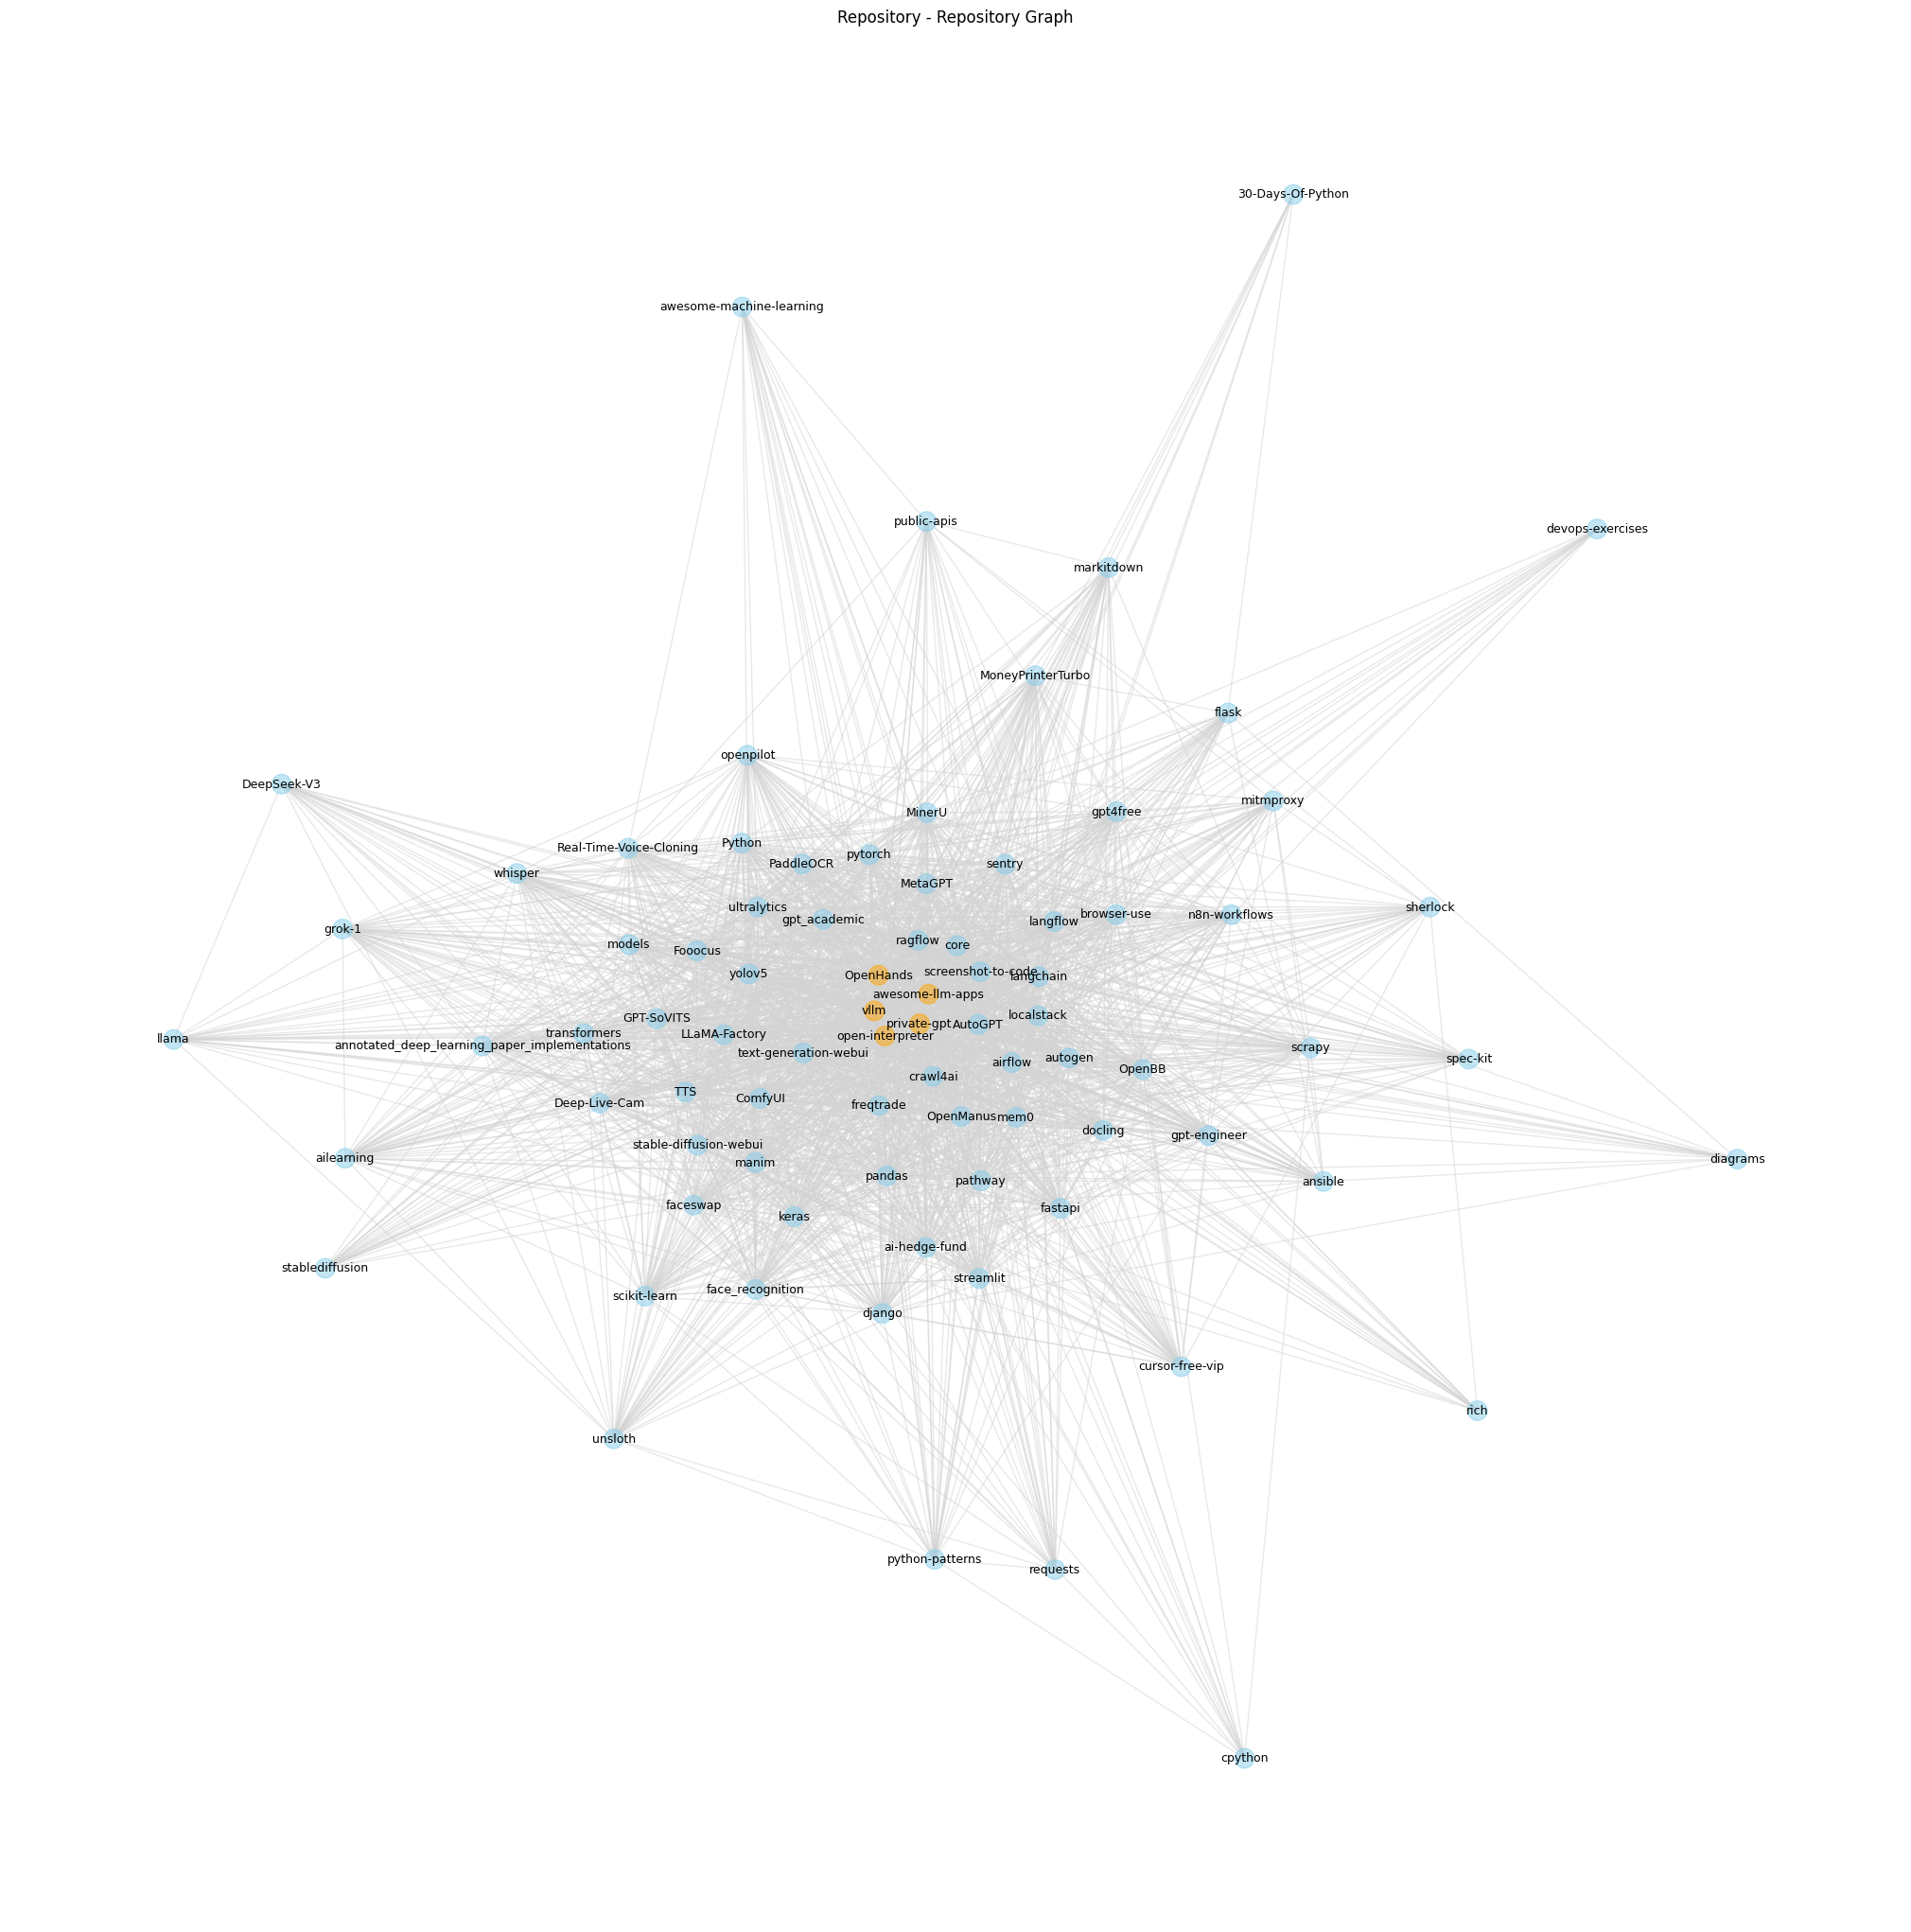

In [9]:
# get top 5 nodes and select colors
top_5_nodes = top_5(repo_deg_cent)
node_colors = ["orange" if n in dict(top_5_nodes) else "skyblue" for n in RG.nodes()]

# create a spring layout
pos = nx.spring_layout(RG, k=4, iterations=1000, seed=42)
plt.figure(figsize=(20, 20))
nx.draw(
    RG, pos, node_color=node_colors, node_size=220, edge_color="lightgrey", alpha=0.5
)

# label repo nodes only to avoid clutter
nx.draw_networkx_labels(RG, pos, labels={r: r for r in repo_nodes}, font_size=9)

plt.title("Repository - Repository Graph")
plt.axis("off")
plt.show()

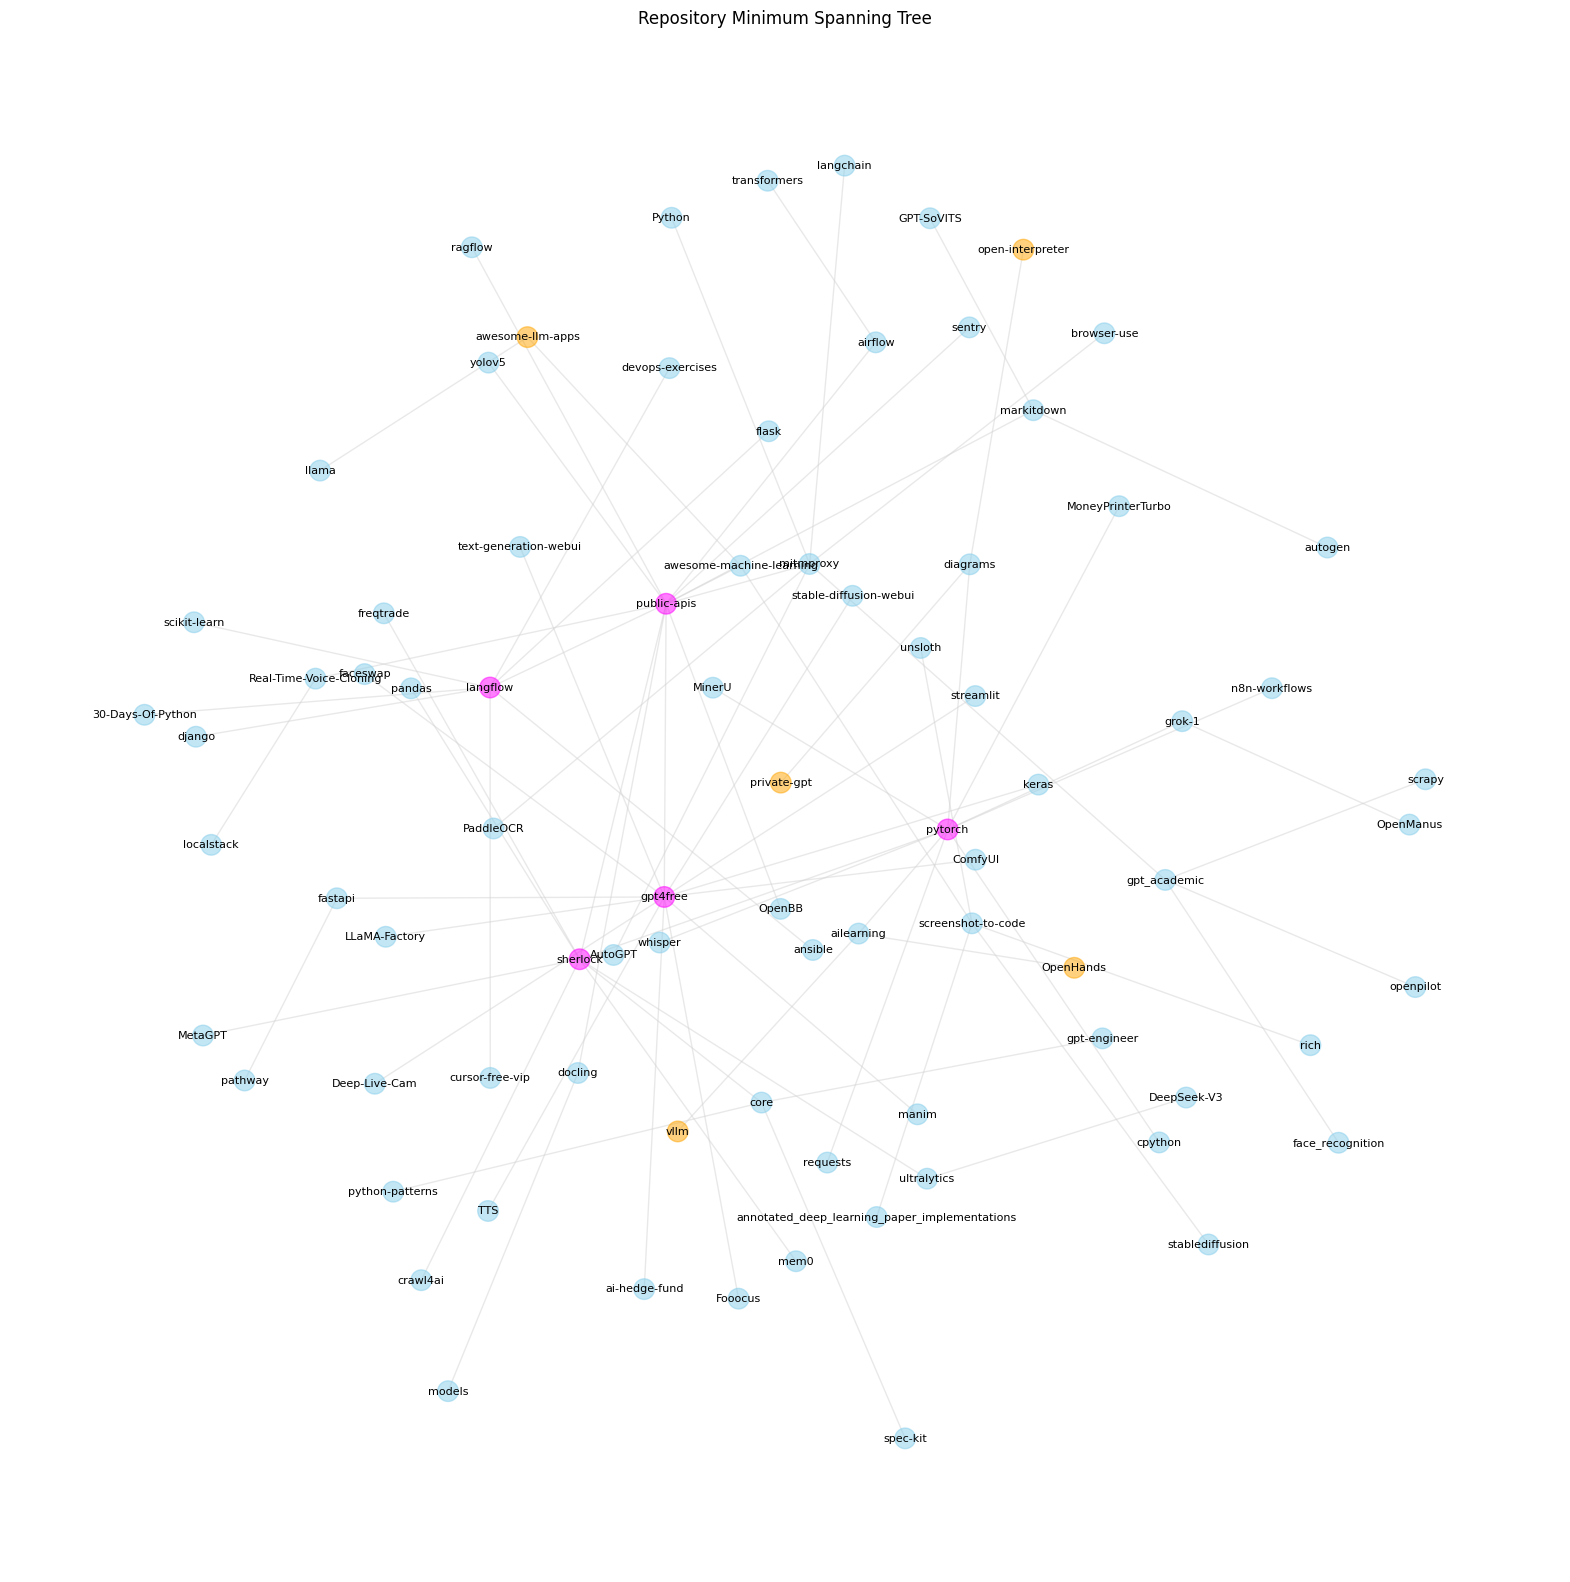

In [10]:
# compute mst using kruskal
mst = nx.minimum_spanning_tree(RG, weight="weight")

# this list has been created manually to highlight visually noticeable hubs
hubs = ["gpt4free", "langflow", "pytorch", "public-apis", "sherlock"]

# get node colors based on top 5 nodes and hubs
node_colors = [
    "orange" if n in dict(top_5_nodes)
    else "magenta" if n in hubs
    else "skyblue"
    for n in mst.nodes()
]

# plot the mst
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(mst, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(mst, pos, node_size=220, node_color=node_colors, alpha=0.5)
nx.draw_networkx_edges(mst, pos, width=1.0, edge_color="lightgrey", alpha=0.5)
nx.draw_networkx_labels(mst, pos, font_size=8)
plt.title("Repository Minimum Spanning Tree")
plt.axis("off")
plt.show()

### Graph Embeddings

In [11]:
# run node2vec to embed all the nodes based on the weights
node2vec = Node2Vec(
    RG,
    dimensions=64,
    walk_length=30,
    num_walks=200,
    p=1.0,
    q=1.0,
    weight_key="weight",
    workers=4,
    seed=42
)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
repo_nodes = list(RG.nodes())
embeddings = np.array([model.wv[str(node)] for node in repo_nodes])
print(f"Embeddings shape: {embeddings.shape}")

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 87.78it/s]
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Embeddings shape: (82, 64)


Embeddings 2D shape: (82, 2)


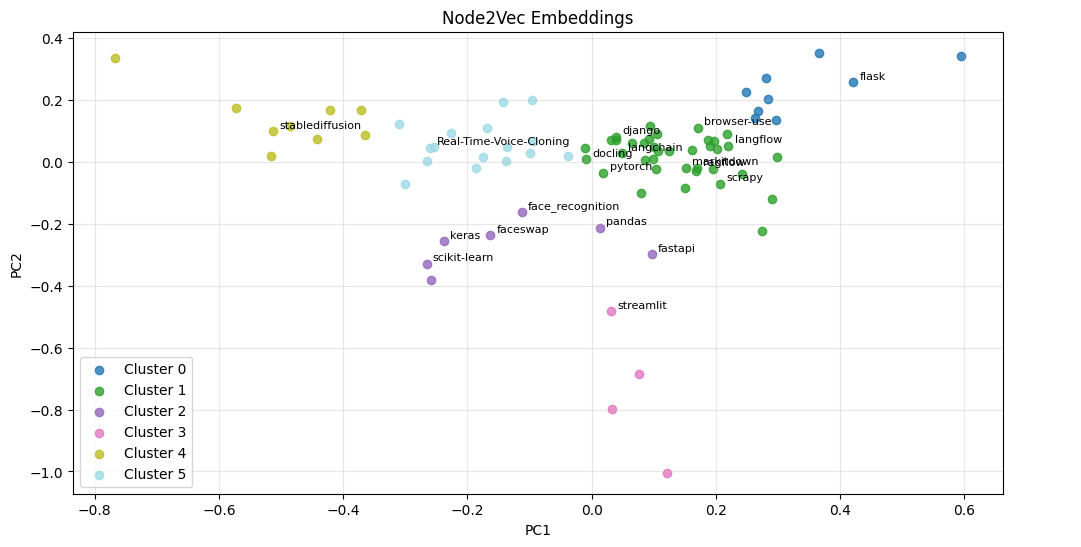

In [12]:
# reduce the embeddings using PCA for visualization
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)
print("Embeddings 2D shape:", emb_2d.shape)

# cluster the embeddings into 6 clusters
k = 6

# k-means
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(emb_2d)

# plot embeddings
cmap = cm.get_cmap("tab20", k)
plt.figure(figsize=(12, 6))
for i in range(k):
    idxs = np.where(labels==i)[0]
    plt.scatter(
        emb_2d[idxs, 0], emb_2d[idxs, 1], color=cmap(i), label=f"Cluster {i}", alpha=0.8
    )
    for j in idxs:
        category = [
            key for key, value in manual_communities.items()
            if repo_nodes[j] in value["nodes"]
        ]
        alpha = 0 if not len(category) else 1
        plt.text(
            emb_2d[j, 0] + 0.01,
            emb_2d[j, 1] + 0.01,
            repo_nodes[j],
            fontsize=8,
            alpha=alpha
        )

plt.title("Node2Vec Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Community Detection

Detected 6 communities in 82 repos


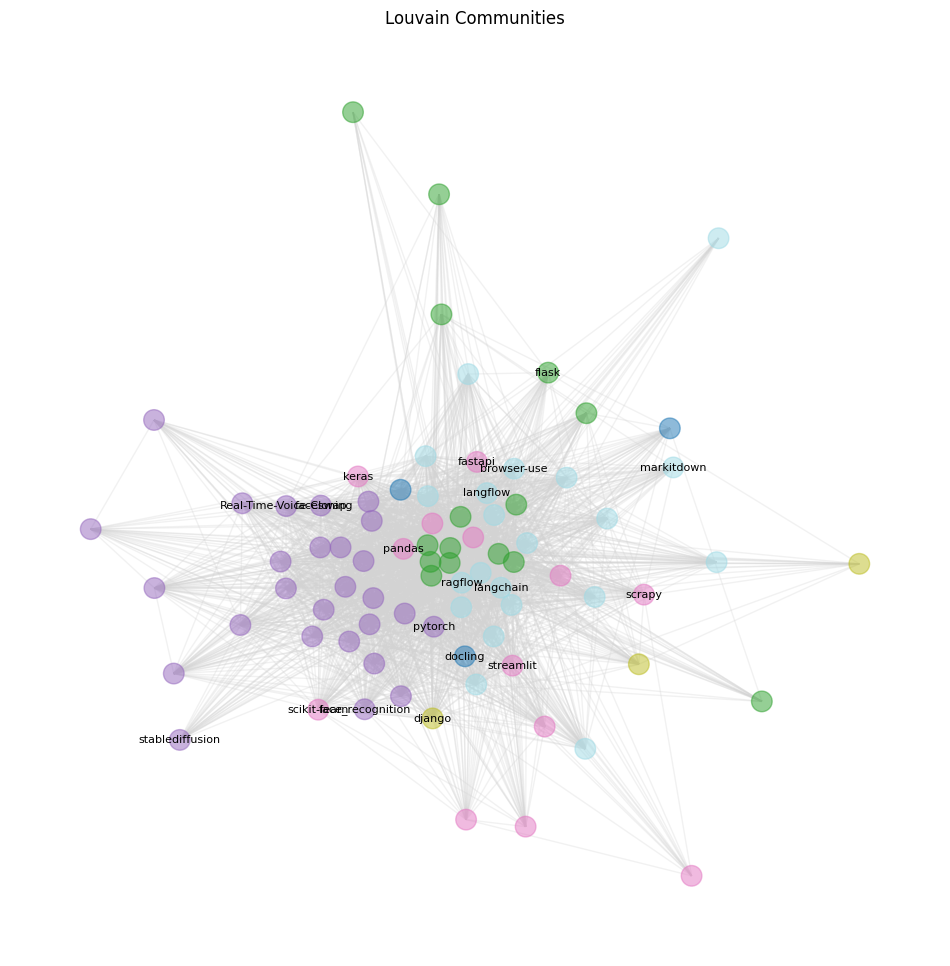

In [13]:
def plot_communities(num_communities, partition, title):
    # color map for plotting
    cmap = cm.get_cmap("tab20", num_communities)
    colors = [cmap(partition[n]) for n in RG.nodes()]

    # get labels
    labels = {}
    for name in RG.nodes():
        category = [
            key for key, value in manual_communities.items()
            if name in value["nodes"]
        ]
        labels[name] = "" if not len(category) else name

    # plot
    pos = nx.spring_layout(RG, k=0.5, iterations=50, seed=42)
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(RG, pos, node_size=220, node_color=colors, alpha=0.5)
    nx.draw_networkx_edges(RG, pos, alpha=0.3, edge_color="lightgrey")
    nx.draw_networkx_labels(RG, pos, labels=labels, font_size=8)
    plt.title(f"{title} Communities")
    plt.axis("off")
    plt.show()

# run louvain
partition = community_louvain.best_partition(RG, weight="weight", resolution=1.2)
num_communities = len(set(partition.values()))
print(f"Detected {num_communities} communities in {len(RG.nodes())} repos")

# plot communities
plot_communities(num_communities, partition, "Louvain")

Leiden: 5 communities detected


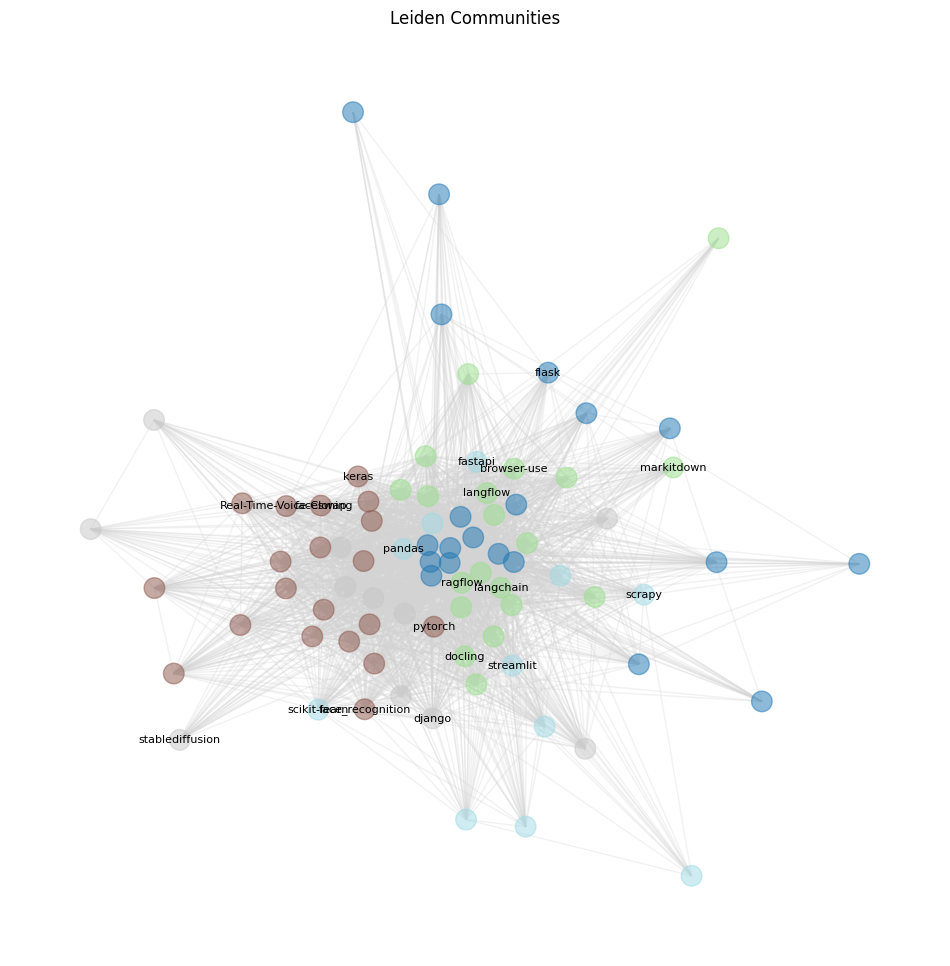

In [14]:
edges = []
for u, v, data in RG.edges(data=True):
    w = float(data.get("weight", 1.0))
    edges.append((u, v, w))

# create igraph
G_igraph = ig.Graph.TupleList(edges, edge_attrs=["weight"], directed=False)

# run Leiden
leiden_partition = leidenalg.find_partition(
    G_igraph,
    leidenalg.ModularityVertexPartition,
    weights="weight",
    seed=42,
    max_comm_size=int(len(RG.nodes()) / 4),
)

# map back to repo names
leiden_labels = {}
for idx, community in enumerate(leiden_partition):
    for node in community:
        leiden_labels[G_igraph.vs[node]["name"]] = idx

num_leiden = len(set(leiden_labels.values()))
print(f"Leiden: {num_leiden} communities detected")

plot_communities(num_leiden, leiden_labels, "Leiden")

### GNN Approach

In [ ]:
# node ordering maps
n = len(repo_nodes)
node2id = {nname: i for i, nname in enumerate(repo_nodes)}
id2node = {i: nname for nname, i in node2id.items()}

# normalize features
embeddings = (embeddings - embeddings.mean(0)) / (embeddings.std(0) + 1e-9)

# build adjacency matrix
A = np.zeros((n, n), dtype=float)
for u, v, data in RG.edges(data=True):
    i = node2id[u]
    j = node2id[v]
    w = float(data.get("weight", 1.0))
    A[i, j] = A[j, i] = w

# add self-loops
A_hat = A + np.eye(n, dtype=float)

# symmetric normalization
D = A_hat.sum(axis=1)
D_inv_sqrt = np.power(D, -0.5)
D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0.0
D_inv_sqrt = np.diag(D_inv_sqrt)
A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt

# convert to torch tensor
X = torch.tensor(embeddings, dtype=torch.float32, device=device)
A_norm_t = torch.tensor(A_norm, dtype=torch.float32, device=device)

In [16]:
class GCNLayer(nn.Module):
    """This is the Message Passing Layer."""

    def __init__(self, in_dim, out_dim, activation=nn.PReLU()):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)
        self.activation = activation

    def forward(self, X, A_norm):
        Z = self.linear(X)
        Z = torch.matmul(A_norm, Z)
        if self.activation is not None:
            Z = self.activation(Z)
        return Z


class GCNEncoder(nn.Module):
    """This is the GCN Encoder, consists of 2 GCN layers."""

    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.gc1 = GCNLayer(in_dim, hidden_dim, activation=nn.PReLU())
        self.gc2 = GCNLayer(hidden_dim, out_dim, activation=None)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, A_norm):
        h = self.gc1(X, A_norm)
        h = self.dropout(h)
        z = self.gc2(h, A_norm)
        return z

In [ ]:
# training config
in_dim = X.shape[1]
hidden_dim = 128
out_dim = 64
lr = 1e-3
weight_decay = 1e-5
epochs = 1200
print_every = 50

# initialize the encoder, loss and optimizer
encoder = GCNEncoder(in_dim, hidden_dim, out_dim, dropout=0.3).to(device)
opt = optim.Adam(encoder.parameters(), lr=lr, weight_decay=weight_decay)
bce = nn.BCEWithLogitsLoss()
X_orig = X.clone().detach()

for epoch in range(1, epochs + 1):
    # set encoder to training mode and clear gradients
    encoder.train()
    opt.zero_grad()

    # compute positive embeddings
    z_pos = encoder(X_orig, A_norm_t)
    s = torch.sigmoid(z_pos.mean(dim=0))

    # corrupt features to compute negative embeddings
    idx = torch.randperm(n)
    X_corrupt = X_orig[idx, :].clone()
    z_neg = encoder(X_corrupt, A_norm_t)

    # get discriminator scores
    pos_scores = torch.matmul(z_pos, s)
    neg_scores = torch.matmul(z_neg, s)

    # compute contrastive loss
    labels_pos = torch.ones(n, device=device)
    labels_neg = torch.zeros(n, device=device)
    loss_pos = bce(pos_scores, labels_pos)
    loss_neg = bce(neg_scores, labels_neg)
    loss = loss_pos + loss_neg

    # backprop
    loss.backward()
    opt.step()

    # logging every 50 epochs
    if epoch % print_every == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch}/{epochs}  loss={loss.item():.4f}")

Epoch 1/1200  loss=1.4815
Epoch 50/1200  loss=0.2908
Epoch 100/1200  loss=0.0738
Epoch 150/1200  loss=0.0312
Epoch 200/1200  loss=0.0281
Epoch 250/1200  loss=0.0188
Epoch 300/1200  loss=0.0061
Epoch 350/1200  loss=0.0134
Epoch 400/1200  loss=0.0094
Epoch 450/1200  loss=0.0239
Epoch 500/1200  loss=0.0050
Epoch 550/1200  loss=0.0188
Epoch 600/1200  loss=0.0031
Epoch 650/1200  loss=0.0019
Epoch 700/1200  loss=0.0069
Epoch 750/1200  loss=0.0010
Epoch 800/1200  loss=0.0012
Epoch 850/1200  loss=0.0006
Epoch 900/1200  loss=0.0006
Epoch 950/1200  loss=0.0039
Epoch 1000/1200  loss=0.0017
Epoch 1050/1200  loss=0.0007
Epoch 1100/1200  loss=0.0015
Epoch 1150/1200  loss=0.0005
Epoch 1200/1200  loss=0.0006


In [18]:
# get embeddings
encoder.eval()
with torch.no_grad():
    Z = encoder(X_orig, A_norm_t)
embs = Z.cpu().numpy()

# cluster
k = 6
kmean = KMeans(n_clusters=k, random_state=42).fit(embs)
labels = kmean.labels_

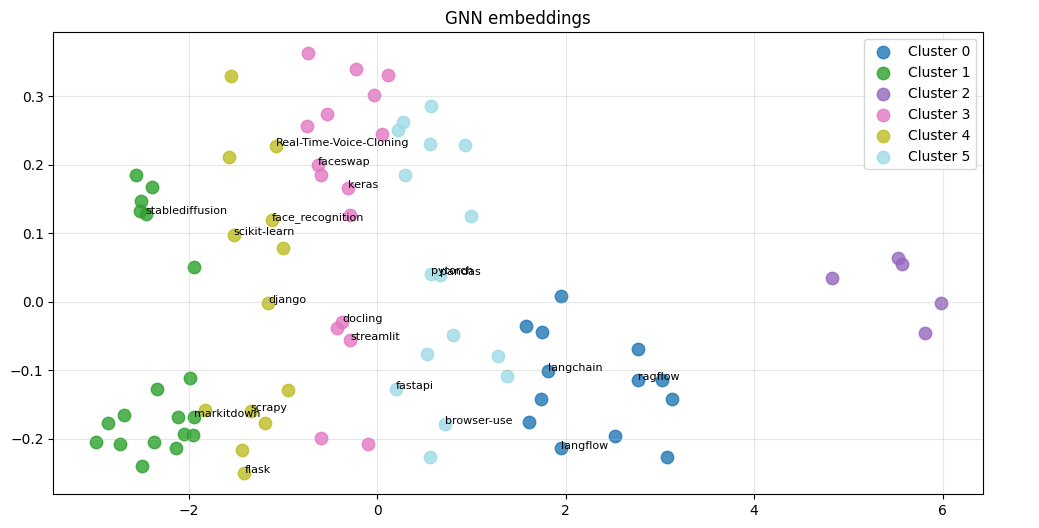

In [ ]:
# visualize with PCA
pca = PCA(n_components=2, random_state=42)
emb2 = pca.fit_transform(embs)

# plot each cluster
cmap = cm.get_cmap("tab20", k)
plt.figure(figsize=(12, 6))
for i in range(k):
    idxs = np.where(labels == i)[0]
    plt.scatter(emb2[idxs,0], emb2[idxs,1], color=cmap(i), label=f"Cluster {i}", s=80, alpha=0.8)

# annotate nodes
for name in deg_cent.keys():
    category = [
        key for key, value in manual_communities.items()
        if name in value["nodes"]
    ]
    alpha = 0 if not len(category) else 1
    if name in node2id:
        idx = node2id[name]
        plt.text(emb2[idx,0], emb2[idx,1], name, fontsize=8, alpha=alpha)

plt.title("GNN embeddings")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()